## Music genre classifier with TensorFlow

The objective of this project is to classify 30 sec wav files by genre using a TensorFLow MLP model. The GTZAN dataset can be found here:

https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification

To classify audio samples, we will preprocess them by calculating their MFCC, which is a temporal representation of the energy for each perceived frequency band. In this case, we are choosing 13 bands.

In [1]:
import os
import json
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
# Dataset location
SOURCE_PATH = 'Dataset/genres_original/'

# Path to labels and processed data file, json format.
JSON = 'data.json'

# Sampling rate.
sr = 22050

# Let's make sure all files have the same amount of samples, pick a duration under 30 seconds.
TOTAL_SAMPLES = 29 * sr

# The dataset contains 999 files. Lets make it bigger! 
# X amount of slices => X times more training examples.
NUM_SLICES = 10

SAMPLES_PER_SLICE = int(TOTAL_SAMPLES / NUM_SLICES)

In [3]:
# Let's create a dictionary of labels and processed data.
mydict = {
    "labels": [],
    "mfcc": []
    }

# Let's browse each file, slice it and generate the mfcc for each slice.
for i, (dirpath, dirnames, filenames) in enumerate(os.walk(SOURCE_PATH)):
    
    for file in filenames:
        song, sr = librosa.load(os.path.join(dirpath, file), duration=29)
        
        for s in range(NUM_SLICES):
            start_sample = SAMPLES_PER_SLICE * s
            end_sample = start_sample + SAMPLES_PER_SLICE
            mfcc = librosa.feature.mfcc(y=song[start_sample:end_sample], sr=sr, n_mfcc=13)
            mfcc = mfcc.T
            mydict["labels"].append(i-1)
            mydict["mfcc"].append(mfcc.tolist())

# Let's write the dictionary in a json file.
with open(JSON, 'w') as fp:
    json.dump(mydict, fp)

In [4]:
with open(JSON) as f:
    data = json.load(f)
fp.close()

# Let's load our data into numpy arrays for TensorFlow compatibility.
inputs = np.array(data["mfcc"])
targets = np.array(data["labels"])

In [5]:
# 9990 mfcc, 13 coefficients, 125 time frames per mfcc.
inputs.shape

(9990, 125, 13)

In [6]:
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.3)

In [7]:
# Let's design the model architecture.
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(inputs.shape[1], inputs.shape[2])),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(len(np.unique(targets)), activation='softmax')
])

In [8]:
# Selection of the optimizer, loss type and metrics for performance evaluation.
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.001),
             loss='sparse_categorical_crossentropy',
              metrics = ['acc']
             )

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1625)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               832512    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                6

In [10]:
#Training the model.
history = model.fit(inputs_train, targets_train, 
                    validation_data=(inputs_test, targets_test), 
                    epochs=50,
                    batch_size=32
                   )

Epoch 1/50
219/219 [==============================] - 5s 18ms/step - loss: 16.2269 - acc: 0.2343 - val_loss: 1.9457 - val_acc: 0.3360
Epoch 2/50
219/219 [==============================] - 3s 13ms/step - loss: 1.8863 - acc: 0.3598 - val_loss: 1.8402 - val_acc: 0.3687
Epoch 3/50
219/219 [==============================] - 3s 13ms/step - loss: 1.6080 - acc: 0.4270 - val_loss: 1.6047 - val_acc: 0.4401
Epoch 4/50
219/219 [==============================] - 3s 13ms/step - loss: 1.4477 - acc: 0.4842 - val_loss: 1.5104 - val_acc: 0.4848
Epoch 5/50
219/219 [==============================] - 3s 13ms/step - loss: 1.3677 - acc: 0.5211 - val_loss: 1.7689 - val_acc: 0.3984
Epoch 6/50
219/219 [==============================] - 3s 13ms/step - loss: 1.3219 - acc: 0.5267 - val_loss: 2.0521 - val_acc: 0.4388
Epoch 7/50
219/219 [==============================] - 3s 13ms/step - loss: 1.3004 - acc: 0.5634 - val_loss: 1.6318 - val_acc: 0.5449
Epoch 8/50
219/219 [==============================] - 3s 13ms/step -

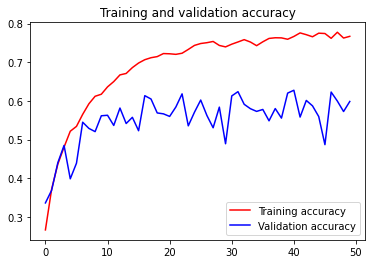

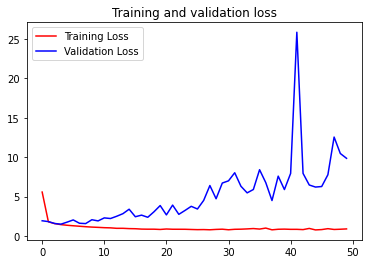

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()